# CLASSIFYING SONG GENRES (HIP-HOP or ROCK)

## 1. Preparing our dataset

Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.

For this reason, streaming services have looked into means of categorizing music to allow for **personalized recommendations**. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. We'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and **classify songs as being either 'Hip-Hop' or 'Rock'** - all without listening to a single one ourselves. 

In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression.

This project invloves the following :
- Data Cleaning
- Exploratory Data Visualizations
- PCA for simplifying the modelling process
- Downsampling to balance our dataset
- Classification using Decision Trees and Logistic Regression

To begin with, let's load the metadata(contains our song genre **labels**) about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as <code>danceability</code>, <code>acousticness</code>, <code>energy</code>, <code>instrumentalness</code>,<code>liveness</code>, <code>speechiness</code>, <code>tempo</code> and <code>valence</code> on a scale from -1 to 1 stored as a json file.

In [1]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv("datasets/fma-rock-vs-hiphop.csv")

# Read in track metrics with the features
echonest_metrics = pd.read_json("datasets/echonest-metrics.json")

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics, tracks[['track_id', 'genre_top']], on='track_id')

# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


In [2]:
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


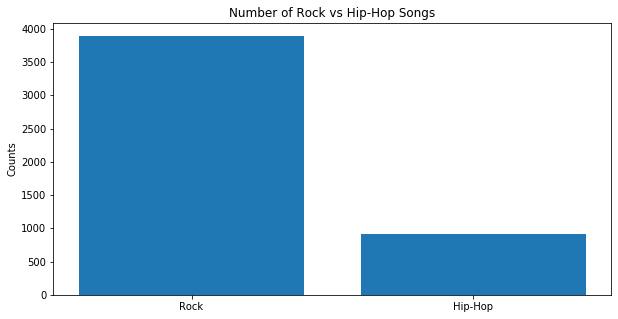

In [20]:
import matplotlib.pyplot as plt

# Get the number of Hip-Hop and Rock songs in the data
counts = echo_tracks.genre_top.value_counts()

# Plot the counts
plt.figure(figsize=(10,5))
plt.bar(x = counts.index, height=counts)
plt.title("Number of Rock vs Hip-Hop Songs")
plt.ylabel("Counts")
plt.show()

## 2. Pairwise relationships between continuous variables

We typically want to avoid using variables that have strong correlations with each other because -

- Fewer features means a simpler and faster model

In [3]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,0.0100698
acousticness,-0.372282,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.0138406
danceability,0.0494541,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.0386027
instrumentalness,-0.275623,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.219967
liveness,0.0482307,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,-0.0450931
speechiness,-0.0269951,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,0.149894
tempo,-0.0253918,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,0.0522212
valence,0.0100698,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,1


## Normalize the data

Since there aren't any significant correlations in the features, we can use **PCA** for feature reduction.

But before that, we will normalize our data since some elements in our data (like *tempo*) lie in a different range from the other features, which can cause bias during feature reduction. 

In [4]:
# Define our features 
features = echo_tracks.drop(['genre_top', 'track_id'], axis=1)

# Define our labels
labels = echo_tracks['genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

## 4. Principal Component Analysis on our scaled data

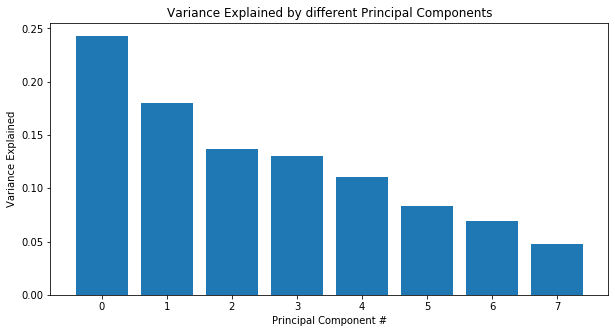

In [5]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(pca.n_components_), exp_variance)
ax.set_title("Variance Explained by different Principal Components")
ax.set_xlabel('Principal Component #')
ax.set_ylabel("Variance Explained")
plt.show()

There is no clear indication here about the number of features we should use.

So we will select a threshold value of 90% i.e. we will select that number of Principal Components to use for our model which explain approximately 90% of the VARIANCE in our data.

We can do this using **Cumulative Explained Variance**.

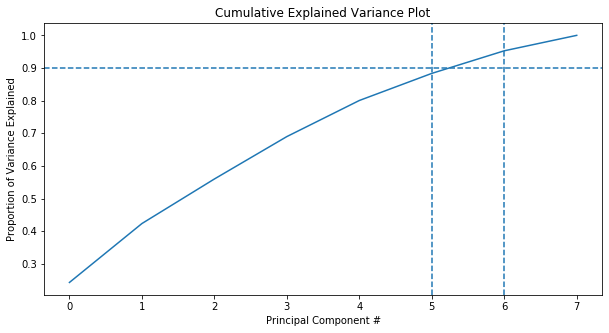

In [22]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cum_exp_variance)
ax.set_title("Cumulative Explained Variance Plot")
ax.set_xlabel("Principal Component #")
ax.set_ylabel("Proportion of Variance Explained")
ax.axhline(y=0.9, linestyle='--') # 0.9 -> 90%
ax.axvline(x=5, linestyle='--')
ax.axvline(x=6, linestyle='--')

We see that the number of Principal Components explaining 90% of the data's variance is slightly higher than 5.

For this reason, we will use 6 components for our feature reduction, just to be safe.

In [7]:
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

## 6. Train a decision tree to classify genre

In [8]:
# Import train_test_split function and Decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Split our data
X_train, X_test, y_train, y_test = train_test_split(pca_projection,labels,random_state=10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(X_train, y_train)

# Predict the labels for the test data
pred_labels_tree = tree.predict(X_test)

# Get score on test data
accuracy = tree.score(X_test, y_test)
print("Decision Tree Accuracy = {}".format(accuracy))

Decision Tree Accuracy = 0.8434637801831807


## 7. Train a Logistic Regression Model to classify genre

In [9]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(X_train, y_train)
pred_labels_logit = logreg.predict(X_test)

# Get score on test data
accuracy = logreg.score(X_test, y_test)
print("Logistic Regression Accuracy = {}".format(accuracy))

Logistic Regression Accuracy = 0.8784346378018318


We can also see other classification metrics such as precision, recall and f1-score using the **classification report** function from scikit-learn.

In [10]:
# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(y_test, pred_labels_tree)
class_rep_log = classification_report(y_test, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



Both our models do similarly well, boasting an average precision of around 85%. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs. 

This might be because we have far more data points for Rock (as seen in the support column of the classification report).
Since the dataset is unbalanced, our model's classification ability is skewed towards Rock songs.

## 8. Balance our data for greater performance

I have used downsampling to solve this problem i.e. resample Rock songs to the same number as Hip-Hop Songs.

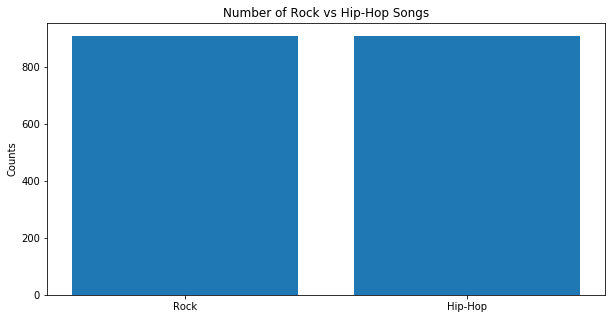

In [23]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks['genre_top']=='Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top']=='Rock']

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(len(hop_only), random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# Confirm that the balancing was successful
counts = rock_hop_bal['genre_top'].value_counts()

# Plot the counts
plt.figure(figsize=(10,5))
plt.bar(x = counts.index, height=counts)
plt.title("Number of Rock vs Hip-Hop Songs")
plt.ylabel("Counts")
plt.show()

Now that our dataset is balanced let's repeat the scaling and the PCA steps that we performed above.

In [12]:
# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

scaled_train_features = scaler.fit_transform(features)
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
X_train, X_test, y_train, y_test = train_test_split(pca_projection, labels, random_state=10)

## 9. Does balancing our dataset improve model bias?

We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. Let's test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance. 

In [13]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(X_train, y_train)
pred_labels_tree = tree.predict(X_test)

# Train our logistic regression on the balanced data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
pred_labels_logit = logreg.predict(X_test)

# Compare the models
print("Decision Tree: \n", classification_report(y_test, pred_labels_tree))
print("Logistic Regression: \n", classification_report(y_test, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.73      0.74       230
        Rock       0.73      0.74      0.73       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.80      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



Now we can see that both Hip-Hop and Rock songs have similar precision, recall and f1-scores for each model respectively.

Therefore, we have successfully reduced the bias in our models' performances.

## 10. Using cross-validation to evaluate our models

To get a good sense of how well our models are actually performing, we can apply K-Fold cross-validation (CV). This step allows us to compare models in a more rigorous fashion.

In [14]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7489010989010989 Logistic Regression: 0.782967032967033


Since our dataset is balanced, ACCURACY is a good metric for evaluating our classification models. 

Both models perform well, but the **Logistic Regression** performs better in this case.

## Summary

Accuracy of final models after **Downsampling and PCA** :
1. Logisitic Regression = **78.29**%
2. Decision Tree = **74.89**%

## Future Work
- Use different methods for modelling, such as SVC or Ensemble methods like Random Forest.
- Use different preprocessing techniques.
- Feature Engineering to create more meaningful features.
